<a href="https://colab.research.google.com/github/Erwdev/Digital-Image-Processing-Class/blob/main/PCD_Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

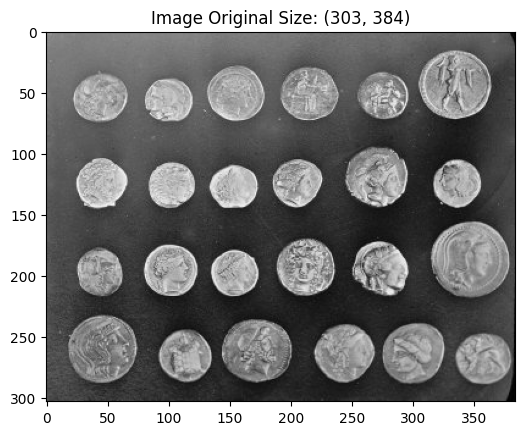

In [11]:
import cv2
from skimage import data
import matplotlib.pyplot as plt
import numpy as np
img = data.coins()
plt.imshow(img, cmap='gray')
plt.title(f"Image Original Size: {img.shape}")
plt.show()


In [24]:
class DownSampler:
  def __init__(self, block_size):
    self.block_size = block_size

  def max_downsample(self, img):
    return self._downsample(img, method='max')

  def average_downsample(self, img):
      return self._downsample(img, method='mean')

  def median_downsample(self, img):
      return self._downsample(img, method='median')
  def _downsample(self, img, method):
    h,w = img.shape
    B = self.block_size
    h_new, w_new = h // B, w // B
    down_img = np.zeros((h_new, w_new), dtype=np.uint8)

    for i in range(h_new):
      for j in range(w_new):
        block = img[i*B:(i+1)*B, j*B:(j+1)*B]
        if method == 'max':
            down_img[i, j] = np.max(block)
        elif method == 'mean':
            down_img[i, j] = np.mean(block)
        elif method == 'median':
            down_img[i, j] = np.median(block)
        else:
            raise ValueError("Unknown method")
    return down_img




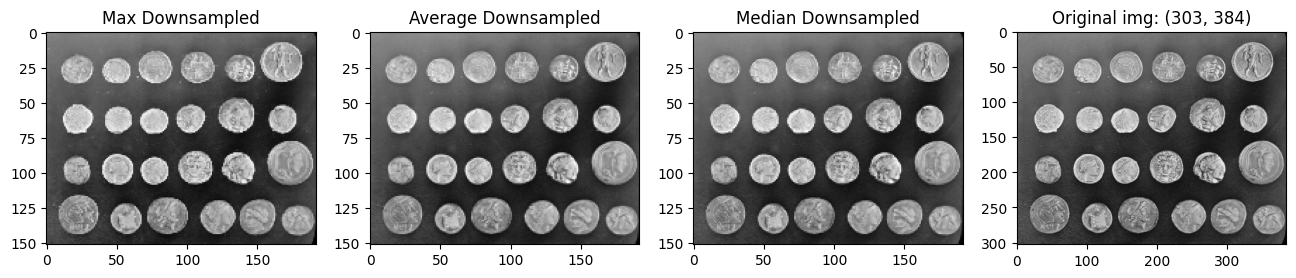

In [50]:
ds = DownSampler(block_size = 2)
img_max = ds.max_downsample(img)
img_avg = ds.average_downsample(img)
img_med = ds.median_downsample(img)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(img_max, cmap='gray')
plt.title('Max Downsampled')
plt.subplot(1,4,2)
plt.imshow(img_avg, cmap='gray')
plt.title('Average Downsampled')
plt.subplot(1,4,3)
plt.imshow(img_med, cmap='gray')
plt.title('Median Downsampled')
plt.subplot(1,4,4)
plt.imshow(img, cmap='gray')
plt.title(f'Original img: {img.shape}')
plt.show()

**Analysis**


*   Max downsampling terlihat lebih terang dibanding kedua metode lainnya, hal ini karena untuk tiap blok dari gambar asli, ia akan mengambil value pixel yang paling maximum
*   Metode mean tidak kebal terhadap outlier atau pada kasus ini pixel yang valuenya tinggi atau sangat rendah. Dibanding dengan menggunakan median yang tahan terhadap outlier
*   Metode max menghasilkan gambar yang pixelated di pinggiran atau aliasing pada gambar yang lebih jelas terlihat dibanding 2 metode lain
* Metode median mempertahankan struktur lokal lebih jelas dibanding metode mean


In [52]:
from google.colab import files
cv2.imwrite("img_max.png", img_max)
cv2.imwrite("img_avg.png", img_avg)
cv2.imwrite("img_med.png", img_med)

files.download("img_max.png")
files.download("img_avg.png")
files.download("img_med.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
class UpSampler:
  def __init__(self, block_size=2):
    self.block_size = block_size

  def nearest_neighbor(self, img):
    h, w = img.shape
    B = self.block_size
    h_up, w_up = h * B , w * B
    up_img = np.zeros((h_up, w_up), dtype = np.uint8)

    for i in range(h_up):
      for j in range(w_up):

        orig_i = i // B
        orig_j = j // B
        up_img[i,j] = img[orig_i, orig_j]

    return up_img

  def bilinear_upsample(self, img):
    h, w = img.shape
    B = self.block_size
    h_up, w_up = h * B , w * B
    up_img = np.zeros((h_up, w_up), dtype = np.float32)

    for i in range(h_up):
      for j in range(w_up):

        y = i/B
        x = j/B

        y0 = int(np.floor(y))
        x0 = int(np.floor(x))
        y1 = min(y0 + 1, h - 1)
        x1 = min(x0 + 1, w - 1)

        dy = y-y0
        dx = x-x0

        Q11 = img[y0,x0]
        Q21 = img[y0,x1]
        Q12 = img[y1,x0]
        Q22 = img[y1,x1]


        value = (Q11*(1-dx)*(1-dy) + Q21*dx*(1-dy) + Q12*(1-dx)*dy + Q22*dx*dy)
        up_img[i,j] = value

    return up_img.astype(np.uint8)

  def bicubic_upsample(self, img):
    h, w = img.shape
    B = self.block_size
    h_up, w_up = h * B, w * B
    up_img = np.zeros((h_up, w_up), dtype=np.float32)

    def cubic(t, a=-0.5):
        t = abs(t)
        if t <= 1:
            return (a + 2) * t**3 - (a + 3) * t**2 + 1
        elif 1 < t <= 2:
            return a * t**3 - 5 * a * t**2 + 8 * a * t - 4 * a
        else:
            return 0

    for i in range(h_up):
        for j in range(w_up):
            y = (i + 0.5) / B - 0.5
            x = (j + 0.5) / B - 0.5


            x0 = int(np.floor(x))
            y0 = int(np.floor(y))

            dx = x - x0
            dy = y - y0

            value = 0.0
            for m in range(-1, 3):
                for n in range(-1, 3):

                    py = max(0, min(y0 + m, h - 1))
                    px = max(0, min(x0 + n, w - 1))
                    pixel = img[py, px]


                    weight_x = cubic(dx - n)
                    weight_y = cubic(dy - m)

                    value += pixel * weight_x * weight_y


            up_img[i, j] = np.clip(value, 0, 255)

    return up_img.astype(np.uint8)

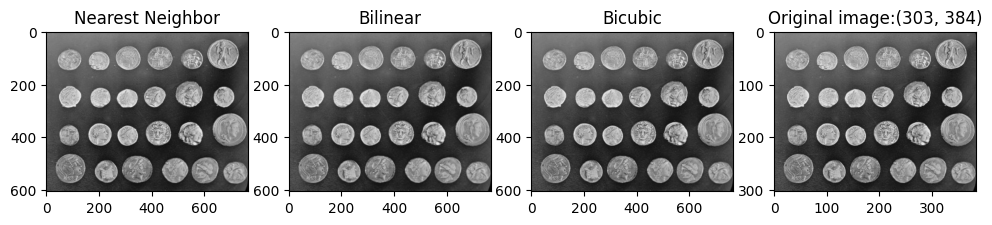

In [48]:
UpsampleImage = UpSampler(block_size = 2)

up_nn = UpsampleImage.nearest_neighbor(img)
up_bilinear = UpsampleImage.bilinear_upsample(img)
up_bicubic = UpsampleImage.bicubic_upsample(img)

plt.figure(figsize=(12,5))
plt.subplot(1,4,1)
plt.imshow(up_nn, cmap='gray'); plt.title("Nearest Neighbor")


plt.subplot(1,4,2)
plt.imshow(up_bilinear, cmap='gray'); plt.title("Bilinear")


plt.subplot(1,4,3)
plt.imshow(up_bicubic, cmap='gray'); plt.title("Bicubic")


plt.subplot(1,4,4)
plt.imshow(img, cmap='gray'); plt.title(f"Original image:{img.shape}")

plt.show()

In [53]:
cv2.imwrite("img_nn.png", up_nn)
cv2.imwrite("img_bil.png", up_bilinear)
cv2.imwrite("img_bic.png", up_bicubic)

files.download("img_nn.png")
files.download("img_bil.png")
files.download("img_bic.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis**


*   Running time dari upsampling dengan metode bicubic yang paling lama diantara ketiganya
*   Upsampling menggunakan metode nearest neighbor menghasilkan gambar yang pixelated pada edge dari objek atau mengakibatkan aliasing
*   Texture pada gambar yang menggunakan metode bilinear terlihat dihasilkan lebih smooth dibanding dengan metode bicubic
*   Metode bicubic dapat menghasilkan beberapa artifak berupa noise yang terlalu tajam pada gambar
